In [ ]:
!pip install pyspark py4j

In [ ]:
from pyspark.sql import SparkSession
spark =  SparkSession.builder.appName("Analysis").getOrCreate()

In [ ]:
df = spark.read.csv("/content/sample_data/online_shoppers_intention.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- Administrative: integer (nullable = true)
 |-- Administrative_Duration: double (nullable = true)
 |-- Informational: integer (nullable = true)
 |-- Informational_Duration: double (nullable = true)
 |-- ProductRelated: integer (nullable = true)
 |-- ProductRelated_Duration: double (nullable = true)
 |-- BounceRates: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- SpecialDay: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: integer (nullable = true)
 |-- Browser: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- TrafficType: integer (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: boolean (nullable = true)
 |-- Revenue: boolean (nullable = true)

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
df = df.withColumn("Weekend_numberic", col("Weekend").cast("double"))

categorical_cols = ["Month", "OperatingSystems", "Browser", "Region",
                    "TrafficType", "VisitorType"]
indexers = [StringIndexer(inputCol = col, outputCol=f'{col}_indexed') for col in categorical_cols]
encoders = [OneHotEncoder(inputCols=[f'{col}_indexed'],outputCols=[f'{col}_encoded']) for col in categorical_cols]
pipeline = Pipeline(stages= indexers + encoders)
df =  pipeline.fit(df).transform(df)
df.show(5)

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+----------------+-------------+------------------------+---------------+--------------+-------------------+-------------------+-------------+------------------------+---------------+--------------+-------------------+-------------------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|Weekend_numberic|Month_indexed|OperatingSystems_indexed|Browser_indexed|Region_indexed|TrafficType_indexed|VisitorType_indexed|Month_encoded|OperatingSystems_encoded|Browser_encoded|Region_encoded|TrafficType_encoded|VisitorType_encoded|
+--------------+--------------------

In [ ]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
numerical_cols = ["Administrative", "Administrative_Duration", "Informational",
                  "Informational_Duration", "ProductRelated", "ProductRelated_Duration",
                  "BounceRates", "ExitRates", "PageValues"]
assembler = VectorAssembler(inputCols=[col for col in numerical_cols], outputCol='numerical_features')
df = assembler.transform(df)
df.show(5)
scaler = StandardScaler(inputCol="numerical_features", outputCol='scaled_features')
df = scaler.fit(df).transform(df)
df.show(5)

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+----------------+-------------+------------------------+---------------+--------------+-------------------+-------------------+-------------+------------------------+---------------+--------------+-------------------+-------------------+--------------------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|Weekend_numberic|Month_indexed|OperatingSystems_indexed|Browser_indexed|Region_indexed|TrafficType_indexed|VisitorType_indexed|Month_encoded|OperatingSystems_encoded|Browser_encoded|Region_encoded|TrafficType_encoded|VisitorType_encoded|  numerical_feat

In [ ]:
feature_cols = [f'{col}_encoded' for col in categorical_cols] +["scaled_features"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)
df.show(5)

+--------------+-----------------------+-------------+----------------------+--------------+-----------------------+-----------+---------+----------+----------+-----+----------------+-------+------+-----------+-----------------+-------+-------+----------------+-------------+------------------------+---------------+--------------+-------------------+-------------------+-------------+------------------------+---------------+--------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|Administrative|Administrative_Duration|Informational|Informational_Duration|ProductRelated|ProductRelated_Duration|BounceRates|ExitRates|PageValues|SpecialDay|Month|OperatingSystems|Browser|Region|TrafficType|      VisitorType|Weekend|Revenue|Weekend_numberic|Month_indexed|OperatingSystems_indexed|Browser_indexed|Region_indexed|TrafficType_indexed|VisitorType_indexed|Month_encoded|OperatingSystems_encoded|Browser_encoded|Region_encoded|TrafficType_en

In [ ]:
from pyspark.sql.functions import when
df = df.withColumn("label", when(col("Revenue") == True, 1.0).otherwise(0.0))

In [ ]:
df.describe(numerical_cols).show()

+-------+------------------+-----------------------+------------------+----------------------+------------------+-----------------------+--------------------+--------------------+-----------------+
|summary|    Administrative|Administrative_Duration|     Informational|Informational_Duration|    ProductRelated|ProductRelated_Duration|         BounceRates|           ExitRates|       PageValues|
+-------+------------------+-----------------------+------------------+----------------------+------------------+-----------------------+--------------------+--------------------+-----------------+
|  count|             12330|                  12330|             12330|                 12330|             12330|                  12330|               12330|               12330|            12330|
|   mean|2.3151662611516626|      80.81861053933578|0.5035685320356853|     34.47239792772309|31.731467964314678|     1194.7462199688305| 0.02219138047072152| 0.04307279776650371|5.889257862693596|
| stddev|3

In [ ]:
df.groupBy("Revenue").count().show()

+-------+-----+
|Revenue|count|
+-------+-----+
|   true| 1908|
|  false|10422|
+-------+-----+



In [ ]:
from pyspark.ml.stat import Correlation
corr_matrix = Correlation.corr(df, "numerical_features").head()
print("Correlation matrix:\n", corr_matrix[0])

Correlation matrix:
 DenseMatrix([[ 1.        ,  0.60158334,  0.37685043,  0.25584814,  0.43111934,
               0.37393901, -0.22356263, -0.316483  ,  0.09898959],
             [ 0.60158334,  1.        ,  0.30270971,  0.23803079,  0.28908662,
               0.35542195, -0.14417041, -0.20579776,  0.06760848],
             [ 0.37685043,  0.30270971,  1.        ,  0.61895486,  0.37416429,
               0.38750531, -0.11611362, -0.16366606,  0.04863169],
             [ 0.25584814,  0.23803079,  0.61895486,  1.        ,  0.28004627,
               0.34736358, -0.07406661, -0.10527568,  0.03086087],
             [ 0.43111934,  0.28908662,  0.37416429,  0.28004627,  1.        ,
               0.86092684, -0.20457763, -0.29252628,  0.05628179],
             [ 0.37393901,  0.35542195,  0.38750531,  0.34736358,  0.86092684,
               1.        , -0.18454112, -0.2519841 ,  0.05282306],
             [-0.22356263, -0.14417041, -0.11611362, -0.07406661, -0.20457763,
              -0.1845411

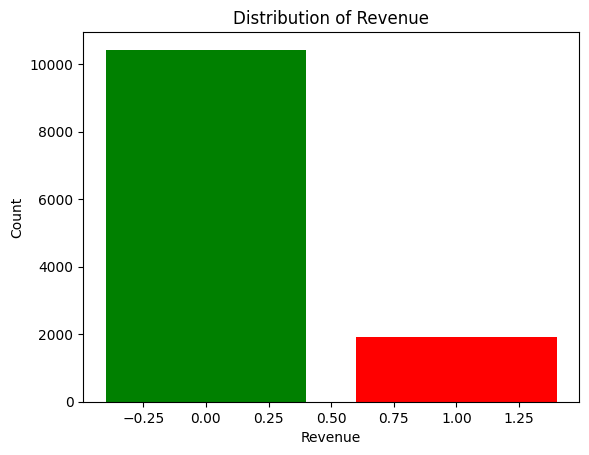

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

revenue_counts = df.groupBy("Revenue").count().toPandas()
plt.bar(revenue_counts["Revenue"], revenue_counts["count"], color=['red', 'green'])
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.title("Distribution of Revenue")
plt.show()

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol="features", labelCol='label')
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.01, 0.1, 1.0]) \
                              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
                              .build()
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
crossVal = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10,
                          seed=42)
cv_model = crossVal.fit(df)
best_model = cv_model.bestModel
avg_metrics = cv_model.avgMetrics
print("AUC trung bình cho mỗi tham số kết hơp: ", avg_metrics)

predictions = best_model.transform(df)
auc = evaluator.evaluate(predictions)
print(f'ROC trên toàn bộ dữ liệu: {auc}')
print("\nAUC trung bình cho từng tổ hợp siêu tham số của LogisticRegression:")
param_combinations = [dict(param_map) for param_map in paramGrid]
results = []
for i, param_map in enumerate(param_combinations):
    param_str = {str(k.name): v for k, v in param_map.items()}
    results.append({**param_str, 'AUC': avg_metrics[i]})
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Tính ROC trên toàn bộ dữ liệu
predictions_lr = best_model.transform(df)
auc_lr = evaluator.evaluate(predictions_lr)
print(f'ROC trên toàn bộ dữ liệu: {auc_lr}')

AUC trung bình cho mỗi tham số kết hơp:  [np.float64(0.8920332893638514), np.float64(0.8982399879902166), np.float64(0.8987539851726115), np.float64(0.881043275302925), np.float64(0.895927810114919), np.float64(0.8629573195327161), np.float64(0.8559804262789786), np.float64(0.5), np.float64(0.5)]
ROC trên toàn bộ dữ liệu: 0.8998238687955284

AUC trung bình cho từng tổ hợp siêu tham số của LogisticRegression:
 regParam  elasticNetParam      AUC
     0.01              0.0 0.892033
     0.01              0.5 0.898240
     0.01              1.0 0.898754
     0.10              0.0 0.881043
     0.10              0.5 0.895928
     0.10              1.0 0.862957
     1.00              0.0 0.855980
     1.00              0.5 0.500000
     1.00              1.0 0.500000
ROC trên toàn bộ dữ liệu: 0.8998238687955284


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10,
                          seed=42)
cv_model = crossval.fit(df)
best_model = cv_model.bestModel
avg_metrics = cv_model.avgMetrics
print("AUC trung bình cho mỗi tham số kết hơp: ", avg_metrics)
predictions = best_model.transform(df)
auc = evaluator.evaluate(predictions)
print(f"ROC trên toàn bộ dữ liệu: {auc}")
print("\nAUC trung bình cho từng tổ hợp siêu tham số của RandomForestClassifier:")
param_combinations = [dict(param_map) for param_map in paramGrid]
results = []
for i, param_map in enumerate(param_combinations):
    param_str = {str(k.name): v for k, v in param_map.items()}
    results.append({**param_str, 'AUC': avg_metrics[i]})
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Tính ROC trên toàn bộ dữ liệu
predictions_rf = best_model.transform(df)
auc_rf = evaluator.evaluate(predictions_rf)
print(f"ROC trên toàn bộ dữ liệu: {auc_rf}")

AUC trung bình cho mỗi tham số kết hơp:  [np.float64(0.9153152480077467), np.float64(0.9253884654113896), np.float64(0.9135122278436978), np.float64(0.9270566626656345)]
ROC trên toàn bộ dữ liệu: 0.96791735713076

AUC trung bình cho từng tổ hợp siêu tham số của RandomForestClassifier:
 numTrees  maxDepth      AUC
       50         5 0.915315
       50        10 0.925388
      100         5 0.913512
      100        10 0.927057
ROC trên toàn bộ dữ liệu: 0.96791735713076


In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(featuresCol="features", labelCol="label", seed=42)
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.stepSize, [0.1, 0.01]) \
    .build()
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=10,
                          seed=42)
cv_model = crossval.fit(df)
best_model = cv_model.bestModel
avg_metrics = cv_model.avgMetrics
print("AUC trung bình cho mỗi tham số kết hơp: ", avg_metrics)
predictions = best_model.transform(df)
auc = evaluator.evaluate(predictions)
print(f"ROC trên toàn bộ dữ liệu: {auc}")
# Hiển thị AUC cho từng tổ hợp siêu tham số
print("\nAUC trung bình cho từng tổ hợp siêu tham số của GBTClassifier:")
param_combinations = [dict(param_map) for param_map in paramGrid]
results = []
for i, param_map in enumerate(param_combinations):
    param_str = {str(k.name): v for k, v in param_map.items()}
    results.append({**param_str, 'AUC': avg_metrics[i]})
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

# Tính ROC trên toàn bộ dữ liệu
predictions_gbt = best_model.transform(df)
auc_gbt = evaluator.evaluate(predictions_gbt)
print(f"ROC trên toàn bộ dữ liệu: {auc_gbt}")

AUC trung bình cho mỗi tham số kết hơp:  [np.float64(0.9307909201487508), np.float64(0.926378762279563), np.float64(0.8985526893535873), np.float64(0.8801303855440683), np.float64(0.9320732177973399), np.float64(0.9272389780800101), np.float64(0.9016742070605342), np.float64(0.8890937305886798)]
ROC trên toàn bộ dữ liệu: 0.9496601136444555

AUC trung bình cho từng tổ hợp siêu tham số của GBTClassifier:
 maxIter  maxDepth  stepSize      AUC
      10         5      0.10 0.930791
      10         5      0.01 0.926379
      10        10      0.10 0.898553
      10        10      0.01 0.880130
      20         5      0.10 0.932073
      20         5      0.01 0.927239
      20        10      0.10 0.901674
      20        10      0.01 0.889094
ROC trên toàn bộ dữ liệu: 0.9496601136444555


In [ ]:
numerical_cols_with_label = numerical_cols + ["label"]
assembler = VectorAssembler(inputCols=numerical_cols_with_label, outputCol="features_with_label")
corr_matrix = Correlation.corr(assembler.transform(df), "features_with_label").head()[0]
print("Correlation matrix:\n", corr_matrix)

Correlation matrix:
 DenseMatrix([[ 1.        ,  0.60158334,  0.37685043,  0.25584814,  0.43111934,
               0.37393901, -0.22356263, -0.316483  ,  0.09898959,  0.13891709],
             [ 0.60158334,  1.        ,  0.30270971,  0.23803079,  0.28908662,
               0.35542195, -0.14417041, -0.20579776,  0.06760848,  0.09358672],
             [ 0.37685043,  0.30270971,  1.        ,  0.61895486,  0.37416429,
               0.38750531, -0.11611362, -0.16366606,  0.04863169,  0.09520034],
             [ 0.25584814,  0.23803079,  0.61895486,  1.        ,  0.28004627,
               0.34736358, -0.07406661, -0.10527568,  0.03086087,  0.0703445 ],
             [ 0.43111934,  0.28908662,  0.37416429,  0.28004627,  1.        ,
               0.86092684, -0.20457763, -0.29252628,  0.05628179,  0.15853798],
             [ 0.37393901,  0.35542195,  0.38750531,  0.34736358,  0.86092684,
               1.        , -0.18454112, -0.2519841 ,  0.05282306,  0.15237261],
             [-0.22356263

In [ ]:
spark.stop()